# News article Classification using ML and DL

## Using Machine Learning

In [ ]:
## Libraries
import nltk
nltk.download("reuters")
nltk.download('stopwords')
from nltk.corpus import reuters, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import random

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Get # of labels and labels
# n_classes = len(reuters.categories()) # 90 classes
# labels = reuters.categories()

### Loading Dataset

In [ ]:
def load_data():
  """
  Returns: dict
    key: "X_train", "X_test", "y_train", "y_test", "labels"
  """
  # Get the labels
  labels = reuters.categories()

  # Get the document ids
  documents_id = reuters.fileids()

  # Dictionary to store documents in for train and test sets
  docs = {}

  # Train document ids
  docs["train_ids"] = [doc for doc in documents_id if doc.startswith("training/")]
  # Test document ids
  docs["test_ids"] = [doc for doc in documents_id if doc.startswith("test/")]

  # Train docs
  docs["train"] = [reuters.raw(doc_id) for doc_id in docs["train_ids"]]
  # Test docs
  docs["test"] = [reuters.raw(doc_id) for doc_id in docs["test_ids"]]

  return docs

In [ ]:
def process_train_test(docs):

  vectorizer = TfidfVectorizer(stop_words=stopwords.words("english")) # Term-Frequency Inverse Document Frequency
  mlb = MultiLabelBinarizer()
    # Train data
  trainData = {"X" : [], # Contains the vectorized document
               "y" : []} # Contains the binary indicator matrix
  # Vectorize the document
  trainData["X"] = vectorizer.fit_transform(docs["train"]).toarray()
  trainData["y"] = mlb.fit_transform([reuters.categories(doc_id) for doc_id in docs["train_ids"]])

  # Test data - same as the train data
  testData = {"X" : [],
               "y" : []}

  testData["X"] = vectorizer.transform(docs["test"]).toarray()
  testData["y"] = mlb.transform([reuters.categories(doc_id) for doc_id in docs["test_ids"]])

  # Storing both test and train data in a single dictionary
  data = {"X_train" : trainData["X"], "y_train" : trainData["y"],
          "X_test" : testData["X"], "y_test" : testData["y"],
          "labels" : reuters.categories()}

  return data, vectorizer, mlb

In [ ]:
# Get the data with the above function

docs = load_data()
data, vectorizer, mlb = process_train_test(docs)
print("len of X_train = {}".format(len(data["X_train"])))
print("Shape of X_train = {}".format(data["X_train"].shape))
print("Shape of y_train = {}".format(data["y_train"].shape))
print("Shape of X_test = {}".format(data["X_test"].shape))
print("Shape of y_test = {}".format(data["y_test"].shape))

len of X_train = 7769
Shape of X_train = (7769, 26147)
Shape of y_train = (7769, 90)
Shape of X_test = (3019, 26147)
Shape of y_test = (3019, 90)


### EDA

In [ ]:
def analyze_data_distribution(dictionary):
  """
  Prints the number of documents labels with a category for both train and test
  sets.

  Also prints the mean number of word in the document of the category
  """
  i = 1
  most_freq_words = sorted(dictionary.items(),
                           key=lambda x: x[1]["train"],
                           reverse=True)
  print("\t# Category Train \tTest\tMean")
  for tup in most_freq_words:
    cate_name = tup[0]
    print("\t{:>2} {:<20} {:>4}\t{:>4}\t{:0.1f}".format(i, cate_name,
                                                        dictionary[cate_name]["train"],
                                                        dictionary[cate_name]["test"],
                                                        np.array(dictionary[cate_name]["words"]).mean()))
    i += 1


def analyze_vocabulary(corpus):
  """
  Computes the character/word count in the dataset.

  Prints the top 10 most frequent character/word
  """
  # Dictionary to store the word count
  word_counts = defaultdict(int)

  # Counts all the word in the corpus
  for word in corpus:
    word_counts[word] += 1

  # Sorts the the dictionary by descending word count
  most_freq = sorted(word_counts.items(), key=lambda n: n[1], reverse=True)

  # Print the top 10 word count
  for i, tup in enumerate(most_freq[:10]):
    print("{}. frequent word is {} ({} occurences)".format(i, tup[0], tup[1]))


  # Create vocabulary
  min_occurences = 20
  max_occurences = 50
  vocabulary = [word[0] for word in word_counts.items()
                 if word[1] >= min_occurences and word[1] <= max_occurences]

  with_oov = True # counting Out of Vocabulary(oov)
  if with_oov:
    word2wid = {"<oov>" : 0}
  else:
    word2wid = {}

  vocabulary = list(vocabulary)
  for wid, word in enumerate(vocabulary, start = len(word2wid)):
    word2wid[word] = wid
  print("Created word2wid")

  # Analyze the vocabulary
  print("Total vocabulary = {}".format(len(word_counts)))
  print("Vocabulary size = {} (min_occ={}, max_occ={})".format(len(word2wid),
                                                               min_occurences,
                                                               max_occurences))
  return most_freq

In [ ]:
def main(categories, document_ids, verbose=False):

  print(f"Categories : {categories}")
  print("Number of categories: {}".format(len(categories)))

  # Documents
  documents = document_ids
  # Train doc
  train = [doc for doc in documents if doc.startswith("training/")]
  # Test doc
  test = [doc for doc in documents if doc.startswith("test/")]

  print("Train documents: {}".format(len(train)))
  print("Test documents: {}".format(len(test)))

  # Stores the document with their labels
  doc_labels = defaultdict(list)
  # Stores categories with their count
  cat_count = {}

  for cat in categories:
    for fid in reuters.fileids(cat):
      doc_labels[fid].append(cat)
      if cat not in cat_count:
        cat_count[cat] = {"train" : 0, "test": 0, "words": []}
      if fid in train:
        cat_count[cat]["train"] += 1
      else:
        cat_count[cat]["test"] += 1

      cat_count[cat]["words"].append(len(reuters.words(fid)))

  print("How many labels do documents usually have?")
  # Counts the number of labels in documents
  label_count_per_doc_count = defaultdict(int)
  for _, cats in doc_labels.items():
    label_count_per_doc_count[len(cats)] += 1

  s = sorted(label_count_per_doc_count.items(), reverse=True, key=lambda x: x[1])

  for labelcount, doccount in s:
    print("\tlabelcount={:>3}, documentcount={:>3}\n".format(labelcount, doccount))

  analyze_data_distribution(cat_count)

  corpus = []
  for doc_id in train:
    corpus += list(reuters.words(doc_id))

  most_freq = analyze_vocabulary(corpus)

  return cat_count, most_freq, s

In [ ]:
# Analyze the dataset
cat_distribution, word_occurence, label_count_per_doc = main(reuters.categories(), reuters.fileids())

Categories : ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
Number of categories: 90
Train documents: 7769
Test documents: 3019
How many 

### Plots

In [ ]:
# Plotting the categories distribution

train_dis = pd.DataFrame([(cat, cat_distribution[cat]["train"]) for cat in cat_distribution],
                         columns=['name', "doc_count"]).reset_index(drop=True).sort_values("doc_count", ascending=False)

test_dis = pd.DataFrame([(cat, cat_distribution[cat]["test"]) for cat in cat_distribution],
                        columns=["name", "doc_count"]).reset_index(drop=True).sort_values("doc_count", ascending=False)

word_mean = pd.DataFrame([(cat, np.array(cat_distribution[cat]["words"]).mean()) for cat in cat_distribution],
                         columns=["name", "mean"]).reset_index(drop=True)

In [ ]:
word_mean["mean"] = word_mean["mean"].apply(lambda x: round(x, 2))

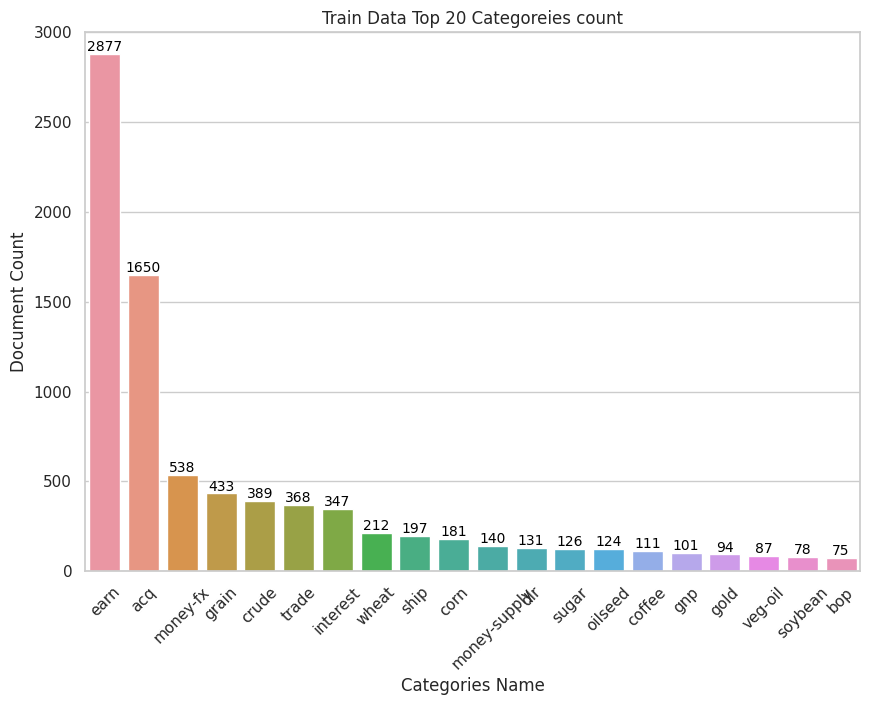

In [ ]:
# Plotting training data distribution of the categories
plt.figure(figsize=(10, 7))
# Plot style
sns.set(style="whitegrid")

# Create Bar plot
ax = sns.barplot(x="name", y="doc_count", data=train_dis.head(20))

# Adding count on top of the bar plot
for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              fontsize=10, color='black',
              xytext=(0, 5), textcoords='offset points')

# Customizing plot
plt.xlabel("Categories Name")
plt.ylabel("Document Count")
plt.title("Train Data Top 20 Categoreies count")
# Rotate x-axis label
plt.xticks(rotation=45)
plt.ylim(0, 3000)
plt.show();

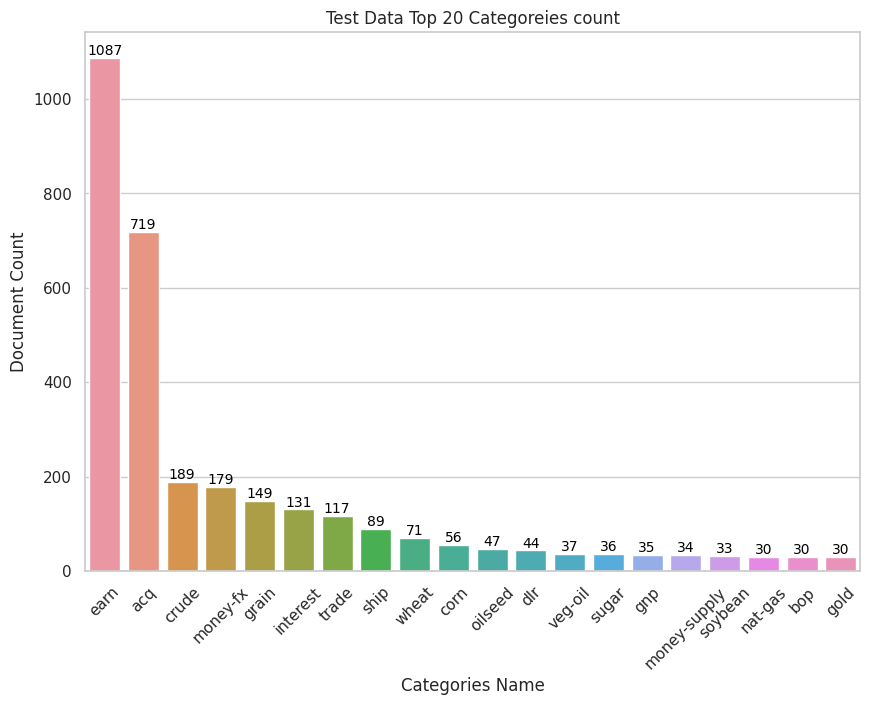

In [ ]:
# Plotting training data distribution of the categories
plt.figure(figsize=(10, 7))
# Plot style
sns.set(style="whitegrid")

# Create Bar plot
ax = sns.barplot(x="name", y="doc_count", data=test_dis.head(20))

# Adding count on top of the bar
for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              fontsize=10, color='black',
              xytext=(0, 5), textcoords='offset points')

# Customizing plot
plt.xlabel("Categories Name")
plt.ylabel("Document Count")
plt.title("Test Data Top 20 Categoreies count")
# Rotate x-axis label
plt.xticks(rotation=45)
# plt.ylim(0, 3000)
plt.show();

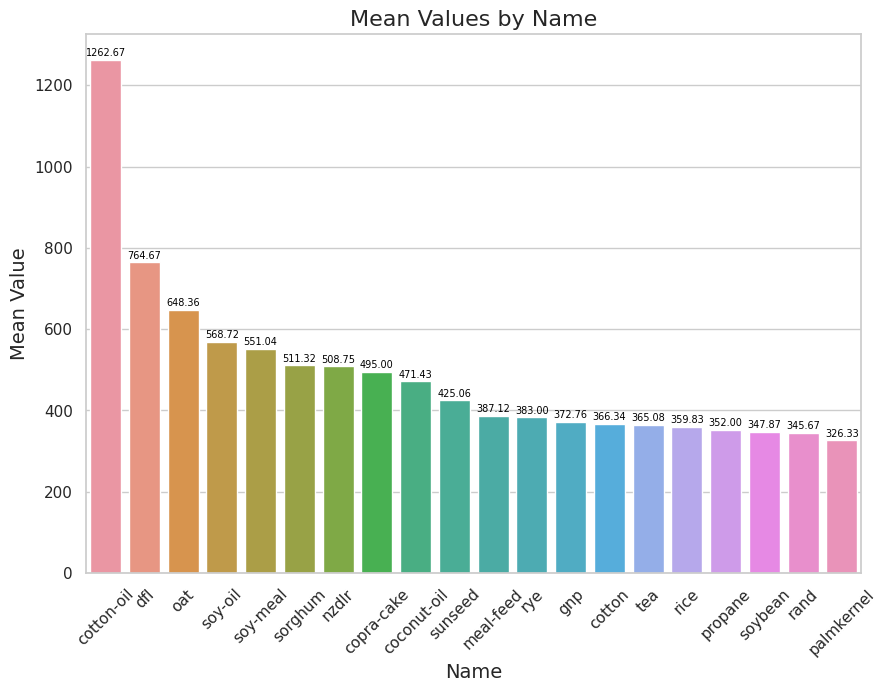

In [ ]:
plt.figure(figsize=(10, 7))  # Set the figure size (optional)
sns.set(style="whitegrid")  # Set the style (optional)

# Create the bar plot
ax = sns.barplot(x='name', y='mean', data=word_mean.sort_values("mean", ascending=False).head(20))

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=7, color='black',
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.xlabel('Name', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.title('Mean Values by Name', fontsize=16)

# Rotate x-axis labels
plt.xticks(rotation=45)



plt.show()

In [ ]:
word_occ_df = pd.DataFrame(word_occurence, columns=["Chars", "count"])
word_occ_df.head()

,Chars,count
0,.,67109
1,",",52334
2,the,43203
3,of,26762
4,to,25690


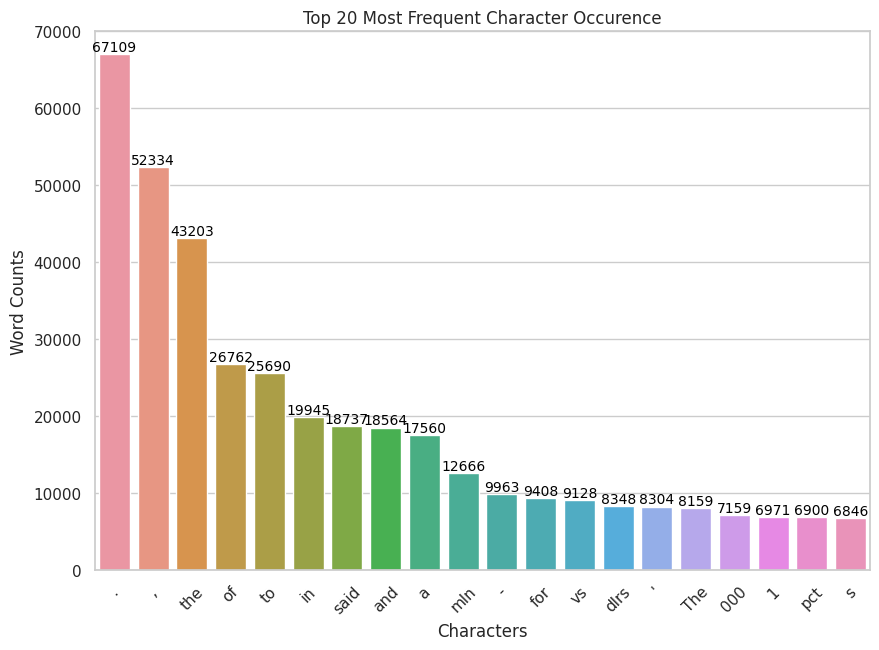

In [ ]:
# Plotting training data distribution of the categories
plt.figure(figsize=(10, 7))

# Plot style
sns.set(style="whitegrid")

# Create Bar plot
ax = sns.barplot(x="Chars", y="count", data=word_occ_df.head(20))

# Adding count on top of the bar
for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              fontsize=10, color='black',
              xytext=(0, 5), textcoords='offset points')

# Customizing plot
plt.xlabel("Characters")
plt.ylabel("Word Counts")
plt.title("Top 20 Most Frequent Character Occurence")
# Rotate x-axis label
plt.xticks(rotation=45)
plt.ylim(0, 70000)
plt.show();

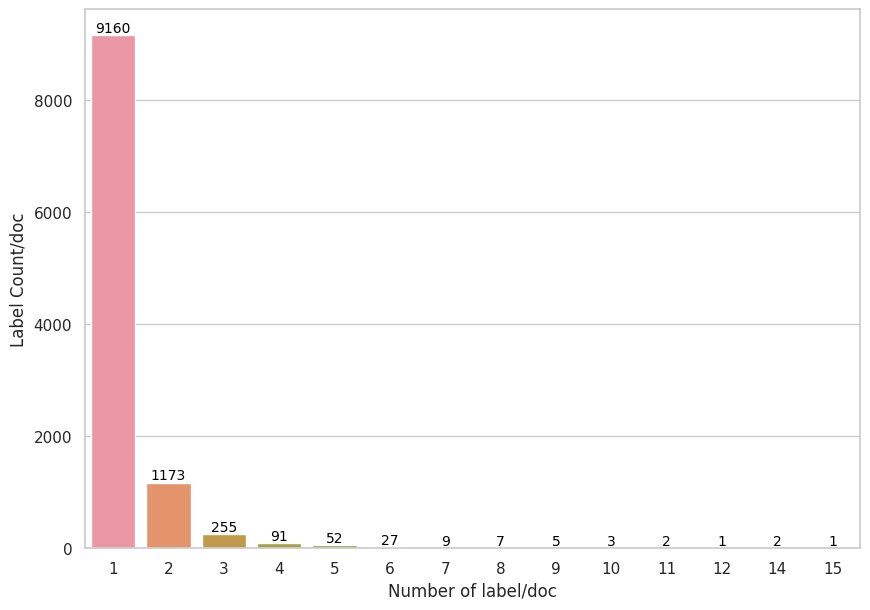

In [ ]:
# Plotting Number of lables per document
label_count_per_doc_df = pd.DataFrame(label_count_per_doc, columns=["Number of label/doc", "Label Count/doc"])

plt.figure(figsize=(10, 7))

# Plot style
sns.set(style="whitegrid")

# Create bar plot
ax = sns.barplot(data=label_count_per_doc_df, x="Number of label/doc", y="Label Count/doc")

# Count on the bar
for p in ax.patches:
  ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
              ha='center', va='center',
              fontsize=10, color='black',
              xytext=(0, 5), textcoords='offset points')

# Customize the plot
# plt.xlabel("")

### Model selection

These are some Machine learning Algorithm I'll be using
1. LogisticRegression
2. KNeighbours
3. RandomForestClassifier
4. DecisionTree
5. Naive Bayes

Then may be use some hyperparameter tuning for the ML algorithm.

Also after these will try to use Deep learning.

In [ ]:
# Importing models from scikit learn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
### First lets just use the model with default parameters and train them

# May be create a list of tuples with classifier name, classifier

# Import time module measure the time taken by each model
import time

# Assuming that the labels dont have any dependencies
# classifiers_independent = [("LogisticRegression", OneVsRestClassifier(LogisticRegression(n_jobs=-1), n_jobs=-1)),
#                           ("Naive Bayes", OneVsRestClassifier(GaussianNB(), n_jobs=-1)),
#                           ("KN-Classifier", KNeighborsClassifier(n_jobs=-1)),
#                           ("RandomForest", RandomForestClassifier(n_jobs=-1)),
#                           ("Decision-Tree", DecisionTreeClassifier())]

def train_classifiers_evaluate(classifiers, X_train, y_train, X_test, y_test, save_specific):
  """
  Train the number of classifier passed to the parameter

  Returns:
    results -> its a dict of classifier cointain dict of score, accuracy, precision, recall, f1 scores
    time -> list of tuples containing
                  time took for training
                  time took for test
                  time took for predicting
  """

  results = {}
  for clf_name, clf in classifiers:
    print("Started {}".format(clf_name))
    start = time.time()

    clf.fit(X_train, y_train)

    end = time.time()

    score = clf.score(X_test, y_test)

    preds = clf.predict(X_test)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    print("Performing evaluations metrics")

    p_score = precision_score(y_test, preds, average="weighted")

    recall = recall_score(y_test, preds, average="weighted")

    f1 = f1_score(y_test, preds, average="weighted")

    # Saving the model

    joblib.dump(clf, f"/content/drive/MyDrive/ML-MiniProjects/ML-models/{clf_name}_{save_specific}.joblib")
    print(f"Saved {clf_name} model\n TIme took to train the model {end-start}")

    results[clf_name] = {"clf" : clf,
                         "score" : score,
                         "precision_score" : p_score,
                         "recall" : recall,
                         "f1" : f1,
                         "train_time" : end-start}

  return results

In [ ]:
lsvc = [("LinearSVC",OneVsRestClassifier(LinearSVC())), ("LinearSVC(C=10)",OneVsRestClassifier(LinearSVC(C=10)))]

In [ ]:
lsvc_results = train_classifiers_evaluate(lsvc, data["X_train"], data["y_train"],
                                          data["X_test"], data["y_test"],
                                          "1")

In [ ]:
# train the model assuming the labels are independent
classifiers_data = train_classifiers_evaluate(classifiers_independent, data["X_train"], data["y_train"], data["X_test"], data["y_test"], "1")

In [ ]:
[clf["score"] for clf in classifiers_data.values()]

[0.6734017886717456,
 0.4385558131831732,
 0.729380589599205,
 0.6455780059622391,
 0.7297118251076515]

In [ ]:
# Store the results in the DataFrame

# Create columns
classifier_df_OR = pd.DataFrame(columns=['Classifiers', "Score",	'precision_score',	'recall',	'f1',	'train_time'])

# Fill the columns with their values
# Classifiers
classifier_df_OR["Classifiers"] = [clf_name for clf_name, clf in classifiers_independent]

# Score
classifier_df_OR["Score"] = [clf["score"] for clf in classifiers_data.values()]

# Precision Score
classifier_df_OR["precision_score"] = [clf["precision_score"] for clf in classifiers_data.values()]

# Recall
classifier_df_OR["recall"] = [clf["recall"] for clf in classifiers_data.values()]

# F1
classifier_df_OR["f1"] = [clf["f1"] for clf in classifiers_data.values()]

# Train Time
classifier_df_OR["train_time"] = [clf["train_time"] for clf in classifiers_data.values()]

In [ ]:
classifier_df_OR.to_csv("classifiers_evaluation_no_tune.csv")

In [ ]:
classifier_df_OR

,Classifiers,Score,precision_score,recall,f1,train_time
0,LogisticRegression,0.673402,0.829107,0.612447,0.670405,651.669979
1,Naive Bayes,0.438556,0.527591,0.455395,0.479751,248.404111
2,KN-Classifier,0.729381,0.828230,0.735310,0.760507,0.295785
3,RandomForest,0.645578,0.828355,0.576656,0.634274,65.912727
4,Decision-Tree,0.729712,0.761127,0.739049,0.743213,54.361474


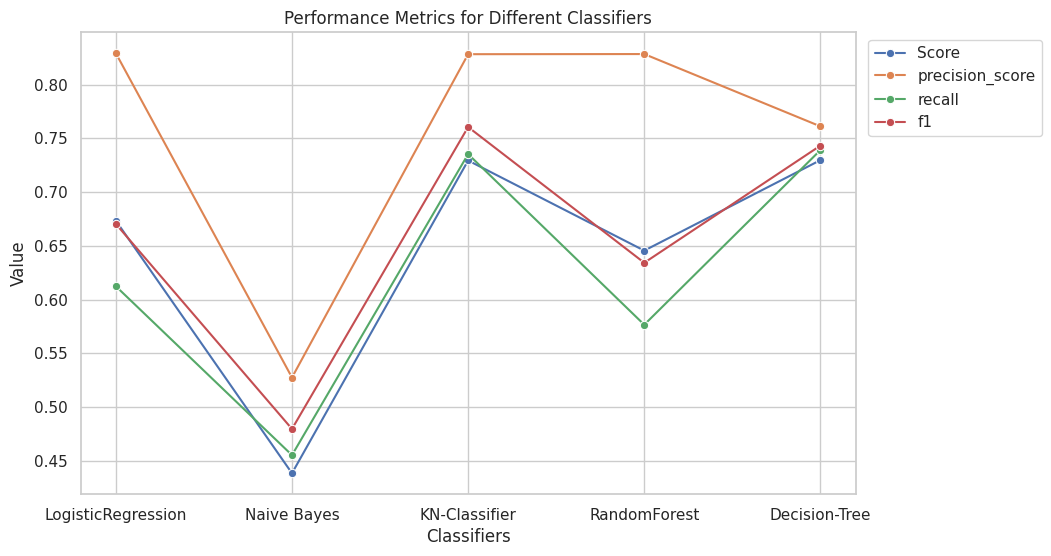

In [ ]:
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
sns.lineplot(x="Classifiers", y="Score", data=classifier_df_OR, label="Score", marker="o")
sns.lineplot(x="Classifiers", y="precision_score", data=classifier_df_OR, label="precision_score", marker="o")
sns.lineplot(x="Classifiers", y="recall", data=classifier_df_OR, label="recall", marker="o")
sns.lineplot(x="Classifiers", y="f1", data=classifier_df_OR, label="f1", marker="o")

# Set labels and title
ax.set(xlabel="Classifiers", ylabel="Value")
plt.title("Performance Metrics for Different Classifiers")

# Add legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

# Show the plot
plt.show()

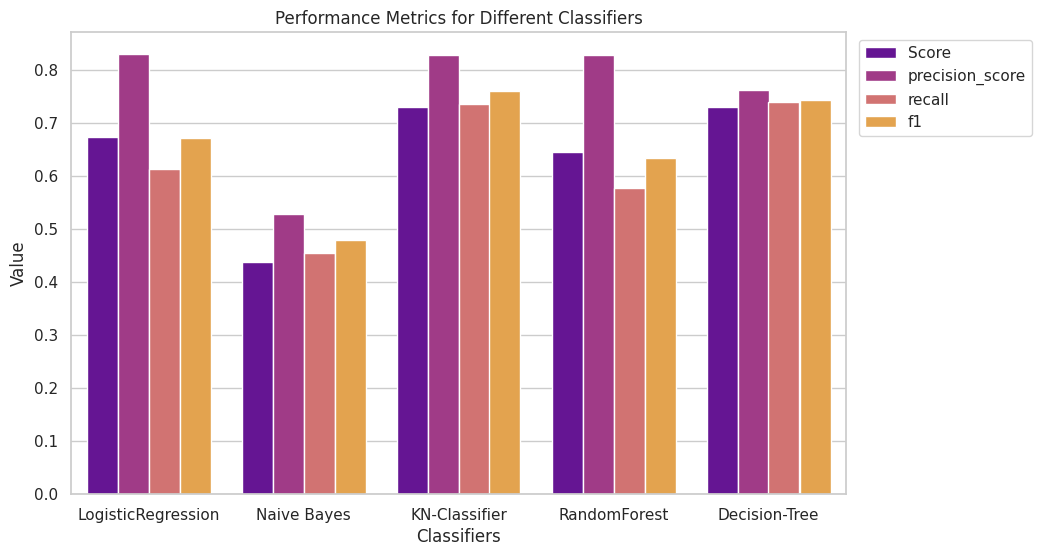

In [ ]:
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Drop the train_time columns
df = classifier_df_OR.drop(columns="train_time")

# Melt the DataFrame for plotting
melted_df = df.melt(id_vars="Classifiers", var_name="Metric", value_name="Value")

# Plot the data using barplot
sns.barplot(x="Classifiers", y="Value", hue="Metric", data=melted_df, palette="plasma") # pastel, muted other palette

# Set labels and title
ax.set(xlabel="Classifiers", ylabel="Value")
plt.title("Performance Metrics for Different Classifiers")

# Add legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

# Show the plot
plt.show()

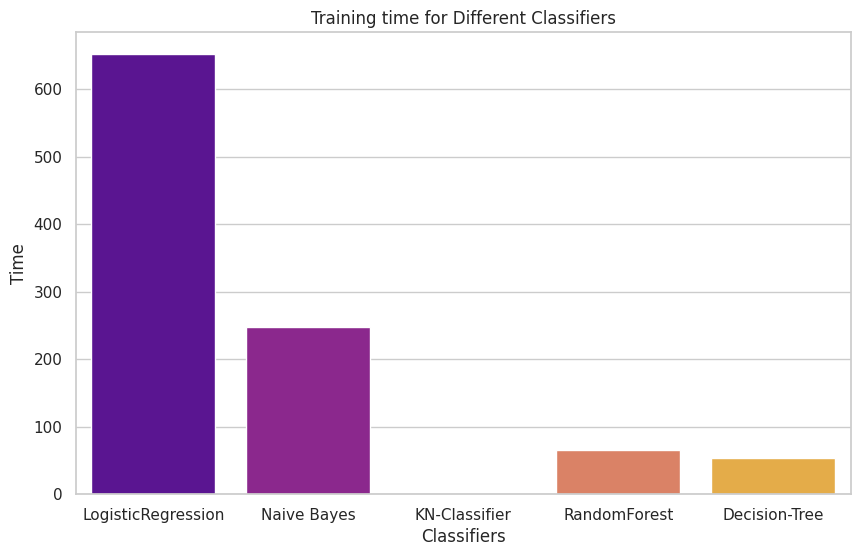

In [ ]:
# Create a figure plot axis
fig, ax = plt.subplots(figsize=(10, 6))

# Select the train_time column and plot using sns
ax = sns.barplot(x="Classifiers", y="train_time", data=classifier_df_OR, palette="plasma")
plt.title("Training time for Different Classifiers")
plt.xlabel("Classifiers")
plt.ylabel("Time")
plt.show()

In [ ]:
  # Train the model assuming the labels might be dependent

# classifiers_dependent = [("LogisticRegression_dep", MultiOutputClassifier(LogisticRegression())),
#                           ("Naive Bayes_dep", MultiOutputClassifier(GaussianNB()))]

# classifier_data_dep, time_list = train_classifiers_evaluate(classifiers_dependent, data["X_train"], data["y_train"], data["X_test"], data["y_test"])



Started LogisticRegression_dep
Performing evaluations metrics
Started Naive Bayes_dep


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performing evaluations metrics


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# classifier_df_MO = pd.DataFrame(classifier_data_dep).T
# classifier_df_MO.to_csv("classifier_MO-Clf_weighted.csv")

There is no difference between `OneVsRestClassifier` and `MultiOutputClassifier`, so from the next step i will not be using `MultiOutputClassifier`.

Basically im just going to assume that the labels associated with the document are totally `independent`.

Changing some parameter in the models

In [ ]:
classifiers_tune = [("LogisticRegression_(c=100)", OneVsRestClassifier(LogisticRegression(C=100, n_jobs=-1), n_jobs=-1)),
                    ("LogisticRegression_(c=1000)", OneVsRestClassifier(LogisticRegression(C=1000, n_jobs=-1), n_jobs=-1)),
                    ("KN-Classifier_(n=3)", KNeighborsClassifier(n_neighbors=3, n_jobs=-1)),
                    ("KN-Classifier_(n=5)", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
                    ("KN-Classifier_(n=10)", KNeighborsClassifier(n_neighbors=10, n_jobs=-1)),
                    ("RandomForest_(n_est=150)", RandomForestClassifier(n_estimators=150, n_jobs=-1)),
                    ("RandomForest_(n_est=200)", RandomForestClassifier(n_estimators=200, n_jobs=-1)),
                    ("RandomForest_(n_est=300)", RandomForestClassifier(n_estimators=300, n_jobs=-1)),
                    ("Decision-Tree_(max_depth=5)", DecisionTreeClassifier(max_depth=5)),
                    ("Decision-Tree_(max_depth=10)", DecisionTreeClassifier(max_depth=10))]

In [ ]:
# Training the tuned models

tuned_classifiers = train_classifiers_evaluate(classifiers_tune,
                                               data["X_train"],
                                               data["y_train"],
                                               data["X_test"],
                                               data["y_test"],
                                               "tuned")

In [ ]:
# Store the result in the DataFrame

# Create columns
classifiers_tuned = pd.DataFrame(columns=['Classifiers', "Score",	'precision_score',	'recall',	'f1',	'train_time'])

# Classifiers
classifiers_tuned["Classifiers"] = [clf_name for clf_name, clf in classifiers_tune]

# Score
classifiers_tuned["Score"] = [clf["score"] for clf in tuned_classifiers.values()]

# Precision Score
classifiers_tuned["precision_score"] = [clf["precision_score"] for clf in tuned_classifiers.values()]

# Recall
classifiers_tuned["recall"] = [clf["recall"] for clf in tuned_classifiers.values()]

# F1
classifiers_tuned["f1"] = [clf["f1"] for clf in tuned_classifiers.values()]

# Train Time
classifiers_tuned["train_time"] = [clf["train_time"] for clf in tuned_classifiers.values()]

In [ ]:
classifiers_tuned

,Classifiers,Score,precision_score,recall,f1,train_time
0,LogisticRegression_(c=100),0.792315,0.914192,0.775908,0.824732,1564.554175
1,LogisticRegression_(c=1000),0.801921,0.914945,0.790064,0.835094,1603.741069
2,KN-Classifier_(n=3),0.723087,0.799497,0.735577,0.754409,0.169942
3,KN-Classifier_(n=5),0.729381,0.828230,0.735310,0.760507,0.246102
4,KN-Classifier_(n=10),0.717456,0.855118,0.698718,0.750361,0.164414
5,RandomForest_(n_est=150),0.648890,0.824307,0.580662,0.638163,138.624173
6,RandomForest_(n_est=200),0.656509,0.818687,0.585470,0.641043,188.156875
7,RandomForest_(n_est=300),0.656840,0.836439,0.585470,0.642587,276.090818
8,Decision-Tree_(max_depth=5),0.557801,0.641610,0.504006,0.532711,39.605947
9,Decision-Tree_(max_depth=10),0.628354,0.732465,0.606571,0.644813,31.472955


In [ ]:
tune_classifiers_df = pd.DataFrame(classifiers_tuned)
tune_classifiers_df.to_csv("/content/drive/MyDrive/ML-MiniProjects/Tuned-classifiers.csv")

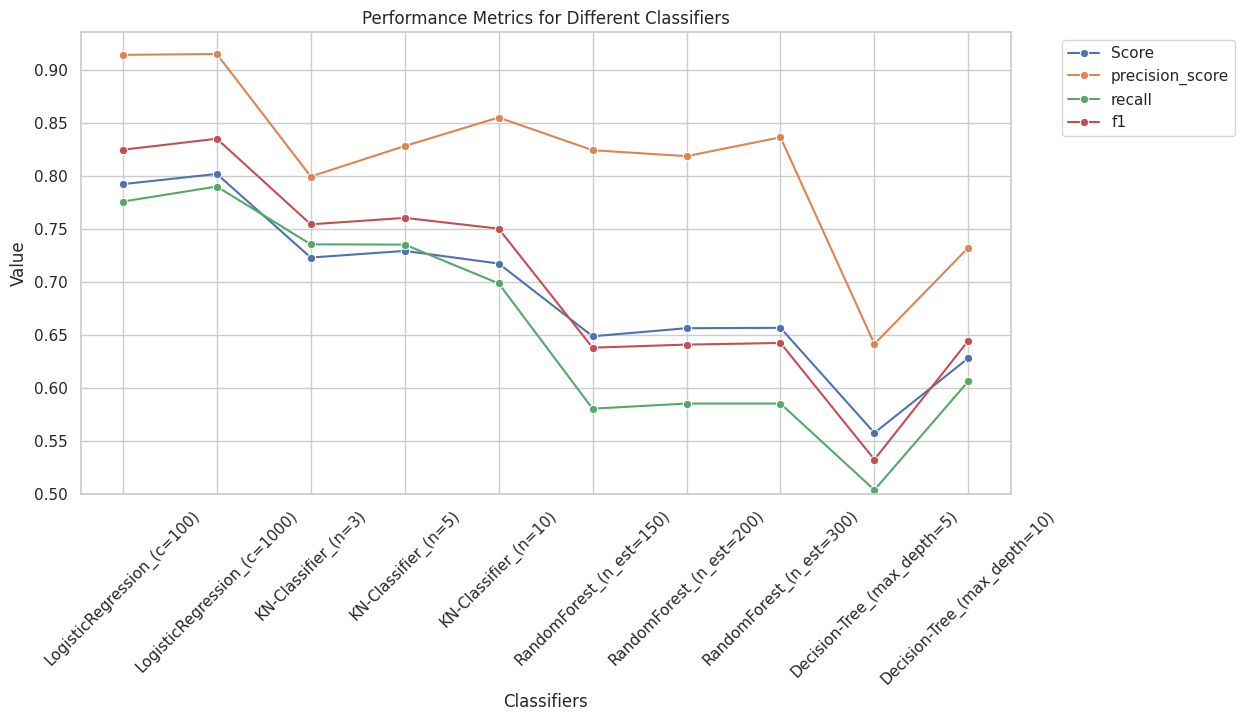

In [ ]:
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
sns.lineplot(x="Classifiers", y="Score", data=tune_classifiers_df, label="Score", marker="o")
sns.lineplot(x="Classifiers", y="precision_score", data=tune_classifiers_df, label="precision_score", marker="o")
sns.lineplot(x="Classifiers", y="recall", data=tune_classifiers_df, label="recall", marker="o")
sns.lineplot(x="Classifiers", y="f1", data=tune_classifiers_df, label="f1", marker="o")

# Set labels and title
ax.set(xlabel="Classifiers", ylabel="Value")
plt.title("Performance Metrics for Different Classifiers")

# Add legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

# Rotate the classifiers name for better readability
plt.xticks(rotation=45)

# Set y limit
plt.ylim(0.5,)
# Show the plot
plt.show()

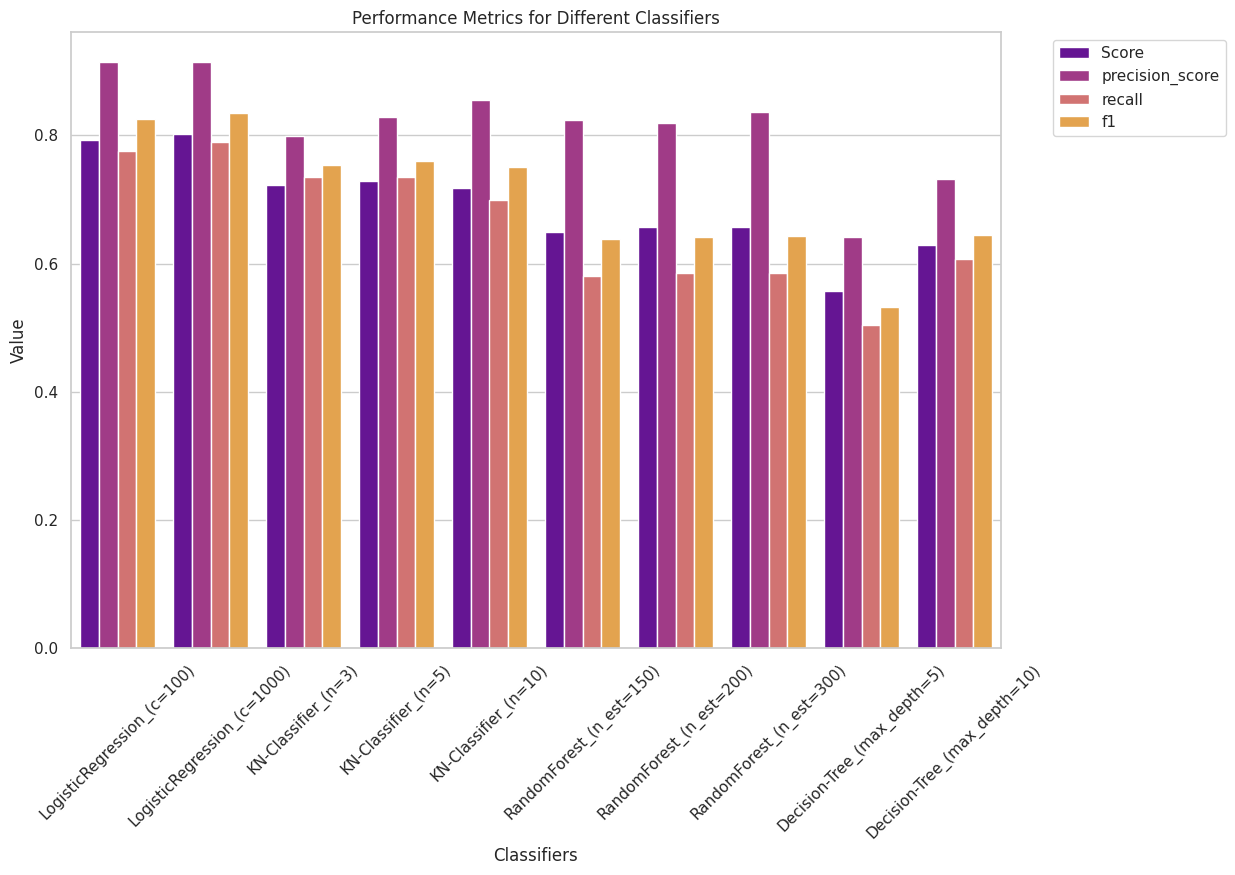

In [ ]:
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Drop the train_time columns
df = tune_classifiers_df.drop(columns="train_time")

# Melt the DataFrame for plotting
melted_df = df.melt(id_vars="Classifiers", var_name="Metric", value_name="Value")

# Plot the data using barplot
sns.barplot(x="Classifiers", y="Value", hue="Metric", data=melted_df, palette="plasma") # pastel, muted other palette

# Set labels and title
ax.set(xlabel="Classifiers", ylabel="Value")
plt.title("Performance Metrics for Different Classifiers")

# Add legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

# Rotate the classifiers name for better readability
plt.xticks(rotation=45)


# Show the plot
plt.show()

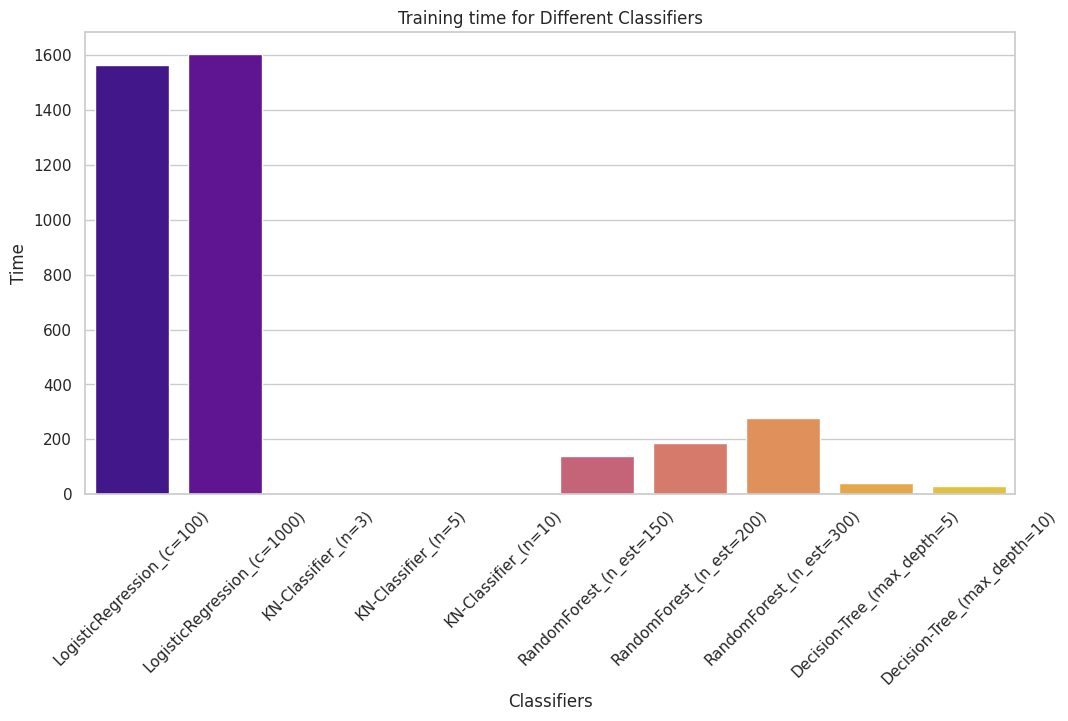

In [ ]:
# Create a figure plot axis
fig, ax = plt.subplots(figsize=(12, 6))

# Select the train_time column and plot using sns
ax = sns.barplot(x="Classifiers", y="train_time", data=tune_classifiers_df, palette="plasma")
plt.title("Training time for Different Classifiers")
plt.xlabel("Classifiers")
plt.ylabel("Time")
plt.xticks(rotation)
plt.show()

In [ ]:
base_model_df = pd.read_csv("/content/drive/MyDrive/ML-MiniProjects/classifiers_evaluation_no_tune.csv")
tuned_model_df = pd.read_csv("/content/drive/MyDrive/ML-MiniProjects/Tuned-classifiers.csv")
tuned_model_df

,Unnamed: 0,Classifiers,Score,precision_score,recall,f1,train_time
0,0,LogisticRegression_(c=100),0.792315,0.914192,0.775908,0.824732,1564.554175
1,1,LogisticRegression_(c=1000),0.801921,0.914945,0.790064,0.835094,1603.741069
2,2,KN-Classifier_(n=3),0.723087,0.799497,0.735577,0.754409,0.169942
3,3,KN-Classifier_(n=5),0.729381,0.828230,0.735310,0.760507,0.246102
4,4,KN-Classifier_(n=10),0.717456,0.855118,0.698718,0.750361,0.164414
5,5,RandomForest_(n_est=150),0.648890,0.824307,0.580662,0.638163,138.624173
6,6,RandomForest_(n_est=200),0.656509,0.818687,0.585470,0.641043,188.156875
7,7,RandomForest_(n_est=300),0.656840,0.836439,0.585470,0.642587,276.090818
8,8,Decision-Tree_(max_depth=5),0.557801,0.641610,0.504006,0.532711,39.605947
9,9,Decision-Tree_(max_depth=10),0.628354,0.732465,0.606571,0.644813,31.472955


In [ ]:
compare_model_df = base_model_df.drop(1).drop(columns="train_time")
compare_model_df["Tuned_Scores"] = [0.801921, 0.729381, 0.656840, 0.628354]
compare_model_df["Tuned_precision_score"] = [0.914945, 0.828230, 0.836439, 0.732465]
compare_model_df["Tuned_recall"] = [0.790064, 0.735310, 0.585470, 0.606571]
compare_model_df["Tuned_f1"] = [0.835094, 0.760507, 0.642587, 0.644813]
compare_model_df = compare_model_df.drop('Unnamed: 0', axis=1)
compare_model_df

,Classifiers,Score,precision_score,recall,f1,Tuned_Scores,Tuned_precision_score,Tuned_recall,Tuned_f1
0,LogisticRegression,0.673402,0.829107,0.612447,0.670405,0.801921,0.914945,0.790064,0.835094
2,KN-Classifier,0.729381,0.828230,0.735310,0.760507,0.729381,0.828230,0.735310,0.760507
3,RandomForest,0.645578,0.828355,0.576656,0.634274,0.656840,0.836439,0.585470,0.642587
4,Decision-Tree,0.729712,0.761127,0.739049,0.743213,0.628354,0.732465,0.606571,0.644813


In [ ]:
compare_model_df

,Classifiers,Score,precision_score,recall,f1,Tuned_Scores,Tuned_precision_score,Tuned_recall,Tuned_f1
0,LogisticRegression,0.673402,0.829107,0.612447,0.670405,0.801921,0.914945,0.790064,0.835094
2,KN-Classifier,0.729381,0.828230,0.735310,0.760507,0.729381,0.828230,0.735310,0.760507
3,RandomForest,0.645578,0.828355,0.576656,0.634274,0.656840,0.836439,0.585470,0.642587
4,Decision-Tree,0.729712,0.761127,0.739049,0.743213,0.628354,0.732465,0.606571,0.644813


In [ ]:
lsvc_results

{'LinearSVC': {'clf': OneVsRestClassifier(estimator=LinearSVC()),
  'score': 0.8105332891685989,
  'precision_score': 0.9231771424515238,
  'recall': 0.7946047008547008,
  'f1': 0.840408128164015,
  'train_time': 104.79650592803955},
 'LinearSVC(C=10)': {'clf': OneVsRestClassifier(estimator=LinearSVC(C=10)),
  'score': 0.8155018217952965,
  'precision_score': 0.9116526612268713,
  'recall': 0.812232905982906,
  'f1': 0.8494727415470317,
  'train_time': 106.02029514312744}}

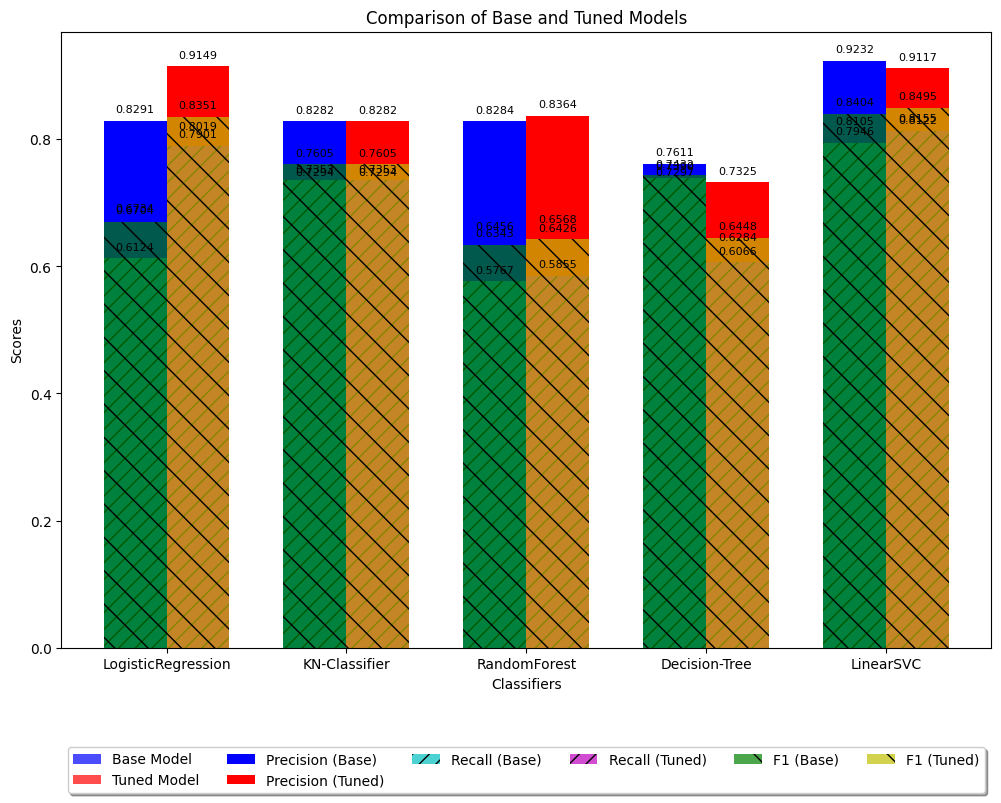

In [ ]:
# Data
classifiers = ['LogisticRegression', 'KN-Classifier', 'RandomForest', 'Decision-Tree', 'LinearSVC']
score_base = [0.673402, 0.729381, 0.645578, 0.729712, 0.810533]
precision_base = [0.829107, 0.828230, 0.828355, 0.761127, 0.923177]
recall_base = [0.612447, 0.735310, 0.576656, 0.739049, 0.794604]
f1_base = [0.670405, 0.760507, 0.634274, 0.743213, 0.840408]

score_tuned = [0.801921, 0.729381, 0.656840, 0.628354, 0.815501]
precision_tuned = [0.914945, 0.828230, 0.836439, 0.732465,  0.911652]
recall_tuned = [0.790064, 0.735310, 0.585470, 0.606571, 0.812232]
f1_tuned = [0.835094, 0.760507, 0.642587, 0.644813, 0.849472]

# Bar width
bar_width = 0.35
index = np.arange(len(classifiers))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plots for base scores
rects1 = ax.bar(index, score_base, bar_width, label='Base Model', color='b', alpha=0.7)
rects2 = ax.bar(index + bar_width, score_tuned, bar_width, label='Tuned Model', color='r', alpha=0.7)

# Add base scores above the bars
def add_base_scores(rects, scores):
    for rect, score in zip(rects, scores):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)

add_base_scores(rects1, score_base)
add_base_scores(rects2, score_tuned)

# Bar plots for precision
rects3 = ax.bar(index, precision_base, bar_width, label='Precision (Base)', color='b')
rects4 = ax.bar(index + bar_width, precision_tuned, bar_width, label='Precision (Tuned)', color='r')

# Bar plots for recall
rects5 = ax.bar(index, recall_base, bar_width, label='Recall (Base)', color='c', alpha=0.7, hatch='//')
rects6 = ax.bar(index + bar_width, recall_tuned, bar_width, label='Recall (Tuned)', color='m', alpha=0.7, hatch='//')

# Bar plots for F1 score
rects7 = ax.bar(index, f1_base, bar_width, label='F1 (Base)', color='g', alpha=0.7, hatch='\\')
rects8 = ax.bar(index + bar_width, f1_tuned, bar_width, label='F1 (Tuned)', color='y', alpha=0.7, hatch='\\')

# Add tuned scores above the bars
def add_tuned_scores(rects, scores):
    for rect, score in zip(rects, scores):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=8)

add_tuned_scores(rects3, precision_base)
add_tuned_scores(rects4, precision_tuned)
add_tuned_scores(rects5, recall_base)
add_tuned_scores(rects6, recall_tuned)
add_tuned_scores(rects7, f1_base)
add_tuned_scores(rects8, f1_tuned)

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Base and Tuned Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers)

# Move the legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)

# Display the plot
plt.show()

We can clearly see that as we increase the c parameter in the logistic regression the accuracy increases, so i think we can increase further to se how much we can increase and then just stop a some point.


But first let's just use `RandomizedSearchCV` and `GridSearchCV` and then may be we can do the hyperparameter tuning according to the above experiments.

### Hyperparameter tuning with RandomSearchCV

In [ ]:
# classifiers_independent = [("LogisticRegression", OneVsRestClassifier(LogisticRegression())),
#                           ("Naive Bayes", OneVsRestClassifier(GaussianNB())),
#                           ("KN-Classifier", KNeighborsClassifier()),
#                           ("RandomForest", RandomForestClassifier()),
#                           ("Decision-Tree", DecisionTreeClassifier())]

# rs_logistic_reg = {'estimator__C': [1500, 2000, 2500, 3000],
#                   'estimator__penalty': ['l2', None],
#                   'estimator__solver': ['lbfgs', 'sag', 'saga'],
#                   'estimator__max_iter': [100, 150, 200, 250, 300]}

# rs_randomforest = {"n_estimators" : np.arange(300, 1000, 100),
#                    "max_depth": [None, 5, 10],
#                    "min_samples_split": [2, 4, 6],
#                    "min_samples_leaf": [1, 3,  5],
#                    "max_features": ['sqrt', 'log2']}

# rs_kneighbors = {"n_neighbors" : np.arange(10, 50, 10),
#                  "weights" : ["uniform", "distance"],
#                  "p" : [1, 2]}

# rs_decisiontree = {"max_depth" : np.arange(1, 10, 2),
#                    "min_samples_split" : np.arange(2, 10, 2),
#                    "min_samples_leaf" : np.arange(1, 10, 2),
#                    "criterion" : ["gini", "entropy", "log_loss"]}

In [ ]:
# # Train logistic regression RandomizedSearchCV

# rs_lr = RandomizedSearchCV(OneVsRestClassifier(LogisticRegression()),
#                            param_distributions=rs_logistic_reg,
#                            n_jobs=-1)
# rs_lr.fit(data["X_train"], data["y_train"])

In [ ]:
# # Train RandomizedSearchCV for RandomForestClassifier
# rs_rf = RandomizedSearchCV(RandomForestClassifier(),
#                            param_distributions=rs_randomforest,
#                            n_jobs=-1)
# rs_rf.fit(data["X_train"], data["y_train"])

In [ ]:
# # Train KNeighbors using RandomizedSearchCV
# rs_knn = RandomizedSearchCV(KNeighborsClassifier(),
#                             param_distributions=rs_kneighbors,
#                             n_jobs=-1)
# rs_knn.fit(data["X_train"], data["y_train"])

In [ ]:
# # Train DecisionTree using RandomizedSearchCV
# rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
#                            param_distributions=rs_decisiontree,
#                            n_jobs=-1)

Training Logistic Regression itself took almost 2 hrs and still did not complete,
I don't think using RandomizedSearchCV or GirdSearchCV is a good idea for this dataset.

Now we'll use Deep learning.

1. First just use some normal layers to train on the dataset
2. Use Conv1D and mya be along with Bi-directional layers to train on the dataset.
3. Then RNN, Bi-Directional with LSTM to train on the dataset.

## Using Deep learning

In [ ]:
import time
import pickle
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Input, Activation
from tensorflow.keras.models import Model

### Creatintg Dataset with Tensorflow

Using Batch processing and Prefetch Processing to speed up training process


tf.compat.v1.losses.sparse_softmax_cross_entropy

In [ ]:
# Batch Size
BATCH_SIZE = 32

def make_dataset(X, y):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.shuffle(BATCH_SIZE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
trainDataset = make_dataset(data["X_train"], data["y_train"])
testDataset = make_dataset(data["X_test"], data["y_test"])
del data

In [ ]:
trainDataset, testDataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 26147), dtype=tf.float64, name=None), TensorSpec(shape=(None, 90), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 26147), dtype=tf.float64, name=None), TensorSpec(shape=(None, 90), dtype=tf.int64, name=None))>)

In [ ]:
(trainDataset.element_spec[1].shape[1])

87

### Building Model 1

A simple Feed Forward Network using Dense layer and dropout layer so that the model does not overfit to the training dataset.

In [ ]:
# Build Model

model_input = Input(shape=(trainDataset.element_spec[0].shape[1],))

# Dense layers
x = Dense(64, activation="relu")(model_input)
x = Dropout(0.5)(x)
# x = Dense(32, activation="relu")(model_input)
# x = Dropout(0.5)(x)
# Output layer
model_output = Dense(trainDataset.element_spec[1].shape[1], activation="sigmoid")(x)
# Final model
model_1 = Model(inputs=model_input, outputs=model_output)

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26092)]           0         
                                                                 
 dense_2 (Dense)             (None, 64)                1669952   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 87)                5655      
                                                                 
Total params: 1675607 (6.39 MB)
Trainable params: 1675607 (6.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Multi-label accuracy
# def multi_label_accuracy(y_true, y_pred, threshold=0.5):
#     # Convert probabilities to binary predictions based on a threshold
#     y_pred_binary = tf.cast(tf.greater(y_pred, threshold), dtype=tf.float32)

#     # Calculate element-wise accuracy for each label
#     correct_predictions = tf.equal(y_true, y_pred_binary)

#     # Calculate the mean accuracy across all labels
#     label_accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32), axis=0)

#     return label_accuracy

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

# Compile the model

# model_1.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=[accuracy])

In [ ]:
# Callbacks

# EarlyStopping stops the training when there is no improvement in the training model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True,
                                                  verbose=1)

# def lr_schedule(epoch, initial_lr):
#     if epoch < 10:
#         return initial_lr
#     else:
#         return initial_lr * 0.1

In [ ]:
start = time.time()
history_model_1 = model_1.fit(trainDataset,
                              epochs=30,
                              validation_data=testDataset,
                              callbacks=[early_stopping])
end = time.time()

243/243 [==============================] - 8s 30ms/step - loss: 0.2374 - accuracy: 0.9674 - val_loss: 0.0548 - val_accuracy: 0.9862


In [ ]:
model_1.save("model_1_dense_drop_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

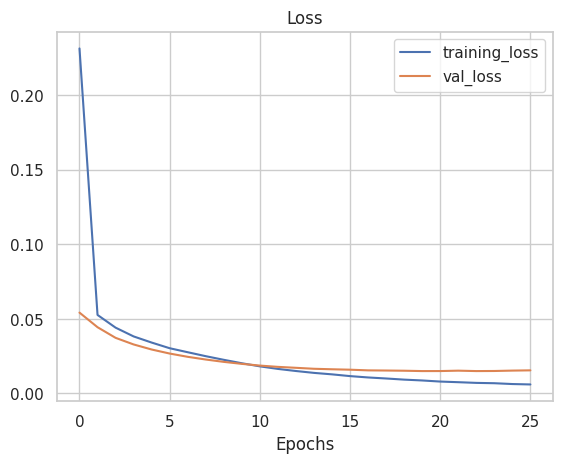

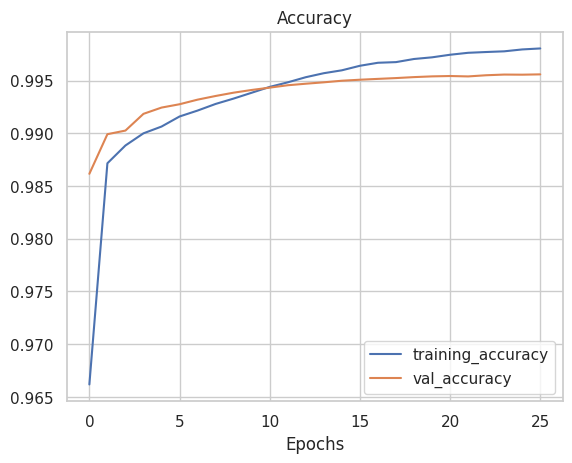

In [ ]:
plot_loss_curves(history_model_1)

### Building model 2

In [ ]:
# Build Model
model_input = Input(shape=(trainDataset.element_spec[0].shape[1],))

# Dense layers
x = Dense(64, activation="relu")(model_input)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(model_input)
x = Dropout(0.5)(x)
# Output layer
model_output = Dense(trainDataset.element_spec[1].shape[1], activation="sigmoid")(x)
# Final model
model_2 = Model(inputs=model_input, outputs=model_output, name="model_2")

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26147)]           0         
                                                                 
 dense_1 (Dense)             (None, 32)                836736    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 90)                2970      
                                                                 
Total params: 839706 (3.20 MB)
Trainable params: 839706 (3.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compilet the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[accuracy])

In [ ]:
# Fit the model
history_model_2 = model_2.fit(trainDataset,
                              epochs=30,
                              validation_data=testDataset,
                              callbacks=[early_stopping])

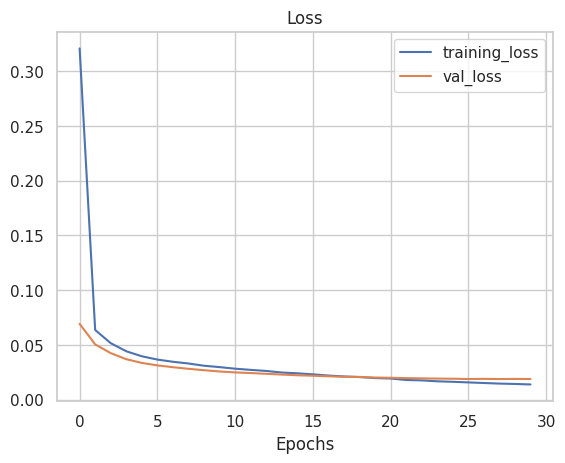

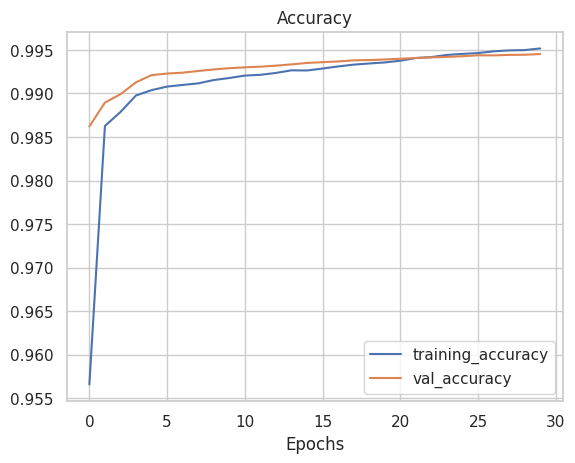

In [ ]:
# Plot the loss curves
plot_loss_curves(history_model_2)

Did not save model 2!

### Building model 3

In [ ]:
# Assuming your input sequence length is 90
sequence_length = trainDataset.element_spec[0].shape[1]

# Build Model
model_input = Input(shape=(sequence_length,))

# Embedding layer for handling sequences
embedded_sequences = layers.Embedding(input_dim=26147, output_dim=50, input_length=sequence_length)(model_input)

# LSTM layer
x = layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, activation="relu")(embedded_sequences)
x = Dropout(0.5)(x)

# Dense layer
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)

# Output layer
model_output = Dense(trainDataset.element_spec[1].shape[1], activation="sigmoid")(x)

# Final model
model_3 = Model(inputs=model_input, outputs=model_output, name="model_3")

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 26147)]           0         
                                                                 
 embedding_2 (Embedding)     (None, 26147, 50)         1307350   
                                                                 
 lstm_2 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 90)                5850

In [ ]:
# Compilet the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_3 = model_3.fit(trainDataset,
                              epochs=10,
                              validation_data=testDataset)

Epoch 1/10
  5/243 [..............................] - ETA: 6:16:03 - loss: 0.6904 - accuracy: 0.0000e+00

In [ ]:
def recall(y_true, y_pred):
    """
    Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    """
    Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.

    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# custom_metric_callback = CustomMetricsCallback(validation_data=val_dataset)

def f1(y_true, y_pred):
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

In [ ]:
# Compile the model
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[accuracy])

In [ ]:
history_model_3 = model_3.fit(train_dataset,
                              epochs=10,
                              validation_data=val_dataset,
                              callbacks=[early_stopping])

Epoch 1/10
38/38 [==============================] - 42s 988ms/step - loss: 0.3248 - accuracy: 0.8764 - val_loss: 0.1167 - val_accuracy: 0.9704
Epoch 2/10
38/38 [==============================] - 33s 866ms/step - loss: 0.1058 - accuracy: 0.9709 - val_loss: 0.1096 - val_accuracy: 0.9704
Epoch 3/10
38/38 [==============================] - 32s 854ms/step - loss: 0.1045 - accuracy: 0.9701 - val_loss: 0.1088 - val_accuracy: 0.9704
Epoch 4/10
38/38 [==============================] - 34s 899ms/step - loss: 0.1043 - accuracy: 0.9709 - val_loss: 0.1085 - val_accuracy: 0.9704
Epoch 5/10
38/38 [==============================] - 33s 876ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.1089 - val_accuracy: 0.9704
Epoch 6/10
38/38 [==============================] - 33s 867ms/step - loss: 0.1042 - accuracy: 0.9709 - val_loss: 0.1086 - val_accuracy: 0.9704
Epoch 7/10
38/38 [==============================] - 34s 887ms/step - loss: 0.1041 - accuracy: 0.9709 - val_loss: 0.1085 - val_accuracy: 0.9704

In [ ]:
model_3.save("/content/drive/MyDrive/ML-MiniProjects/ML-models/model_4_bi-dir")

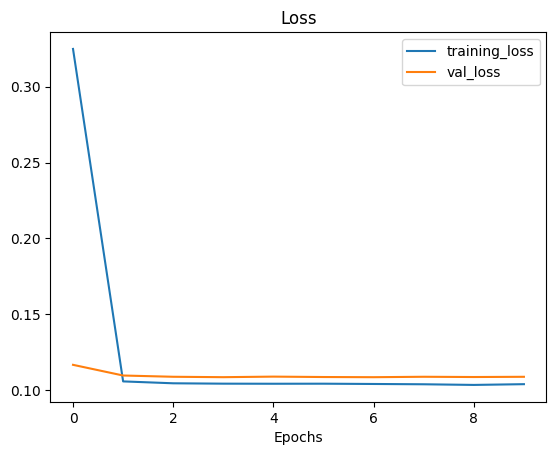

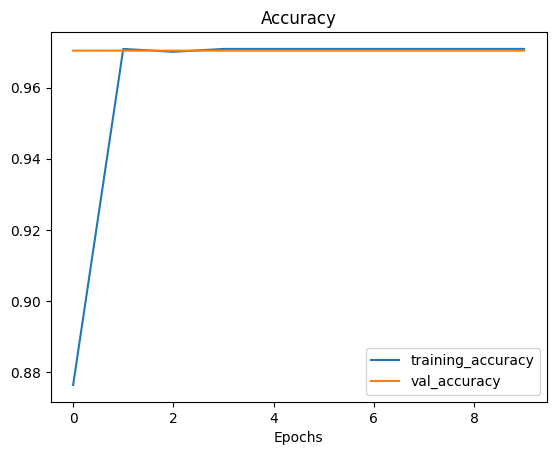

In [ ]:
plot_loss_curves(history_model_3)

## Predictions and plotting

In [ ]:
def process_data(data, labels, vectorizer, mlb):

  x = vectorizer.transform(data).toarray()
  y = mlb.transform(labels)

  return x, y

In [ ]:
def select_random_doc(docs, vectorizer, mlb):

  doc_id = random.choice(docs)
  _file = reuters.raw(doc_id)
  _file_categories = reuters.categories(doc_id)
  print(_file[:10],"\n", _file_categories)

  x, y = process_data([_file], [_file_categories], vectorizer, mlb)

  return x, y

In [ ]:
def pred_plot(array, model, vectorizer, mlb):

  # Select a random document from the test set
  x, y = select_random_doc(array, vectorizer, mlb)

  # Predict on the test set
  preds = model.predict(x)
  print(preds)
  # Set threshold value
  threshold = 0.5
  # List to store the predict categories
  predicted_categories = []
  print(preds.shape[0], preds.shape[1])
  # Iterate through each example in the predictions
  for i in range(preds.shape[0]):

    # Iterate through each category
    for j in range(preds.shape[1]):
        if preds[i, j] > threshold:
            predicted_categories.append(reuters.categories()[j])

    # print(f"Example {i + 1} - Predicted Categories: {predicted_categories}")
  unique_preds_category = list(predicted_categories)
  print(unique_preds_category)

In [ ]:
selected_documents = []
label_count_threshold = 2

for file_id in reuters.fileids():
    labels = reuters.categories(file_id)
    if len(labels) >= label_count_threshold and len(labels) < 9:
      if file_id not in docs["train_ids"]:
        selected_documents.append(file_id)
len(selected_documents)

429

In [ ]:
# dl_model = tf.keras.models.load_model("/content/drive/MyDrive/ML-MiniProjects/model_1_dense_drop_1.h5")
# log_reg_1000 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/LogisticRegression_(c=1000)_tuned.joblib")
# dt_10 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/Decision-Tree_(max_depth=10)_tuned.joblib")
# lscv = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/LinearSVC.joblib")
# linearsvc = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/LinearSVC.joblib")

In [ ]:
pred_plot(selected_documents, model_3, vectorizer, mlb)

PAPERS SAY 
 ['interest', 'money-fx']
1/1 [==============================] - 0s 319ms/step
[[0.04140903 0.00382485 0.02456204 0.05040512 0.03817978 0.00203176
  0.00674862 0.00356904 0.00350062 0.01584828 0.016156   0.00102487
  0.12038496 0.01727126 0.00118854 0.01507032 0.14291416 0.00163223
  0.06338786 0.00625523 0.04067915 0.00947189 0.02927328 0.05363164
  0.02390945 0.2963777  0.00350717 0.00300117 0.00726984 0.01645667
  0.00128109 0.00206879 0.18805657 0.00624622 0.0098833  0.00246894
  0.00774912 0.00524065 0.00998635 0.00126178 0.05458529 0.01478023
  0.29503167 0.01583859 0.00205903 0.05080378 0.00506184 0.00162886
  0.00125231 0.0084662  0.09166929 0.00301808 0.00222485 0.02448726
  0.00101616 0.00545917 0.00396869 0.00345137 0.00154934 0.00417349
  0.01395714 0.01721551 0.00403139 0.03207008 0.00399802 0.00109555
  0.08329325 0.01351108 0.01760057 0.00876931 0.01040312 0.06598577
  0.00635834 0.01879497 0.00139455 0.00361322 0.0074433  0.00524791
  0.00118199 0.11080691 0

## Evaluating models with `accuracy_score`

In [ ]:
# LogisticRegression_(c=1000)_tuned
log_reg_1000 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/LogisticRegression_(c=1000)_tuned.joblib")
lr_preds_1000 = log_reg_1000.predict(data["X_test"])
print("LogisticRegression_(c=1000)_tuned:", accuracy_score(data["y_test"], lr_preds_1000))

# LogisticRegression_(c=100)_tuned
log_reg_100 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/LogisticRegression_(c=100)_tuned.joblib")
lr_preds_100 = log_reg_100.predict(data["X_test"])
print("LogisticRegression_(c=100)_tuned:", accuracy_score(data["y_test"], lr_preds_100))

# KN-Classifier_(n=10)_tuned
# knn_10 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/KN-Classifier_(n=10)_tuned.joblib")
# knn_preds_10 = knn_10.predict(data["X_test"])
# print("KN-Classifier_(n=10)_tuned:", accuracy_score(data["y_test"], knn_preds_10))

# # KN-Classifier_(n=5)_tuned
# knn_5 = joblib.load("/content/drive/MyDrive/ML-MiniProjects/ML-models/KN-Classifier_(n=5)_tuned.joblib")
# knn_preds_5 = knn_5.predict(data["X_test"])
# print("KN-Classifier_(n=5)_tuned:", accuracy_score(data["y_test"], knn_preds_5))

LogisticRegression_(c=1000)_tuned: 0.8019211659489898
LogisticRegression_(c=100)_tuned: 0.792315336204041
KN-Classifier_(n=10)_tuned: 0.7174561112951309
KN-Classifier_(n=5)_tuned: 0.729380589599205


In [ ]:
from sklearn.svm import LinearSVC

lsvc_clf = OneVsRestClassifier(LinearSVC())

lsvc_results_1 = train_classifiers_evaluate([("LinearSVC", lsvc_clf)], data["X_train"], data["y_train"],
                                          data["X_test"], data["y_test"],
                                          "1")

Started LinearSVC
Performing evaluations metrics


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved LinearSVC model
 TIme took to train the model 99.69460773468018


In [ ]:
lsvc_results_1

{'LinearSVC_10': {'clf': OneVsRestClassifier(estimator=LinearSVC(C=10)),
  'score': 0.8155018217952965,
  'precision_score': 0.9116526612268713,
  'recall': 0.812232905982906,
  'f1': 0.8494727415470317,
  'train_time': 103.02472233772278},
 'LinearSVC_100': {'clf': OneVsRestClassifier(estimator=LinearSVC(C=100, max_iter=2000)),
  'score': 0.813183173236171,
  'precision_score': 0.9124957554018305,
  'recall': 0.8106303418803419,
  'f1': 0.8488211627275962,
  'train_time': 108.58468079566956},
 'LinearSVC_1000': {'clf': OneVsRestClassifier(estimator=LinearSVC(C=1000, max_iter=5000)),
  'score': 0.8005962239152037,
  'precision_score': 0.9025189516284462,
  'recall': 0.8047542735042735,
  'f1': 0.8412000544548154,
  'train_time': 116.28157234191895}}

In [ ]:
joblib.dump(lsvc_results_1["LinearSVC"]["clf"], "/content/drive/MyDrive/ML-MiniProjects/ML-models/LinearSVC.joblib")

['/content/drive/MyDrive/ML-MiniProjects/ML-models/LinearSVC.joblib']

In [ ]:
lsvc_preds = lsvc_results_1["LinearSVC"]["clf"].predict(data["X_test"])
accuracy_score(data["y_test"], lsvc_preds)

0.8105332891685989

In [ ]:
lsvc_clf_10 = OneVsRestClassifier(LinearSVC(C=10))
lsvc_clf_100 = OneVsRestClassifier(LinearSVC(C=100, max_iter=2000))
lsvc_clf_1000 = OneVsRestClassifier(LinearSVC(C=1000, max_iter=5000))

lsvc_classifiers = [("LinearSVC_10", lsvc_clf_10), ("LinearSVC_100", lsvc_clf_100), ("LinearSVC_1000", lsvc_clf_1000)]
lsvc_results = train_classifiers_evaluate(lsvc_classifiers, data["X_train"], data["y_train"],
                                          data["X_test"], data["y_test"],
                                          "1")

In [ ]:
lsvc_preds_10 = lsvc_results["LinearSVC_10"]["clf"].predict(data["X_test"])
print(accuracy_score(data["y_test"], lsvc_preds_10))

lsvc_preds_100 = lsvc_results["LinearSVC_100"]["clf"].predict(data["X_test"])
print(accuracy_score(data["y_test"], lsvc_preds_100))

lsvc_preds_1000 = lsvc_results["LinearSVC_1000"]["clf"].predict(data["X_test"])
print(accuracy_score(data["y_test"], lsvc_preds_1000))

0.8155018217952965
0.813183173236171
0.8005962239152037


# Conclusion

Well I tried some 4 to 6 different data but both the models did not perform well on it so in the next experiment I will use some pretrained word embedding such as Word2Vec etc, and then train the model.

I think that may be some other vectoriezer may be help full in generating/predicting labels for the data which the model has not seen.

Tf-IDF does not maintain `word order`, `contextual information` and can't handle `OOV` words.

So may be using other `word embedding` such as `Word2Vec`, `GolVe` or `contextual embedding` such as `BERT` or `GPT-3` to face these issues.

And also I might use only the `LinearSVC`, `LogisticRegression(C=1000)` and `MLP` models to train the data on because so far these model have only given better performance on the data.